<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/BandOffSet_LOCPOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/usnistgov/intermat.git@develop ase

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 55.0 MB/s eta 0:00:00


In [2]:
%%capture
!wget https://github.com/usnistgov/intermat/raw/refs/heads/main/intermat/tests/forpytest.zip

In [3]:
%%capture
!unzip forpytest.zip

In [4]:
!cp   forpytest/Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp_OPT/opt_Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp/opt_Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp/LOCPOT  .
!cp   forpytest/Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp_OPT/opt_Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp/opt_Interface-JVASP-1002_JVASP-1174_film_miller_1_1_0_sub_miller_1_1_0_film_thickness_16_subs_thickness_16_seperation_2.5_disp_0.5_0.2_vasp/OUTCAR  .


New approach, using np.traz

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:02<00:00, 17.8MiB/s]


Loading the zipfile...
Loading completed.
Atoms(symbols='As12Ga12Si24', pbc=True, cell=[[0.002228, 5.5913, -0.003881], [7.884492, -0.002696, 0.625022], [-2.057968, -0.01637, -24.091262]])
gap OUTCAR (0.6234999999999999, 5.2089, 4.5854) 4.7982
avg_mx 0.4470960134154023
left_side [ 0.26940398  2.15523187  4.10841075  6.06158963  8.01476851  9.96794739
 11.85377528] 7 3
right_side [13.94165615 16.09688802 18.18476889 20.27264977 22.42788163] 5 2
Left Repeat Unit: [4.108410749810933, 6.061589630868589]
Right Repeat Unit: [18.184768892605767, 20.272649765460503]
Integral over Left-Hand Side Repeat Unit: -10.993212027567518
Integral over Right-Hand Side Repeat Unit: -8.392714196392216
Difference Between Integrals: 2.6004978311753018


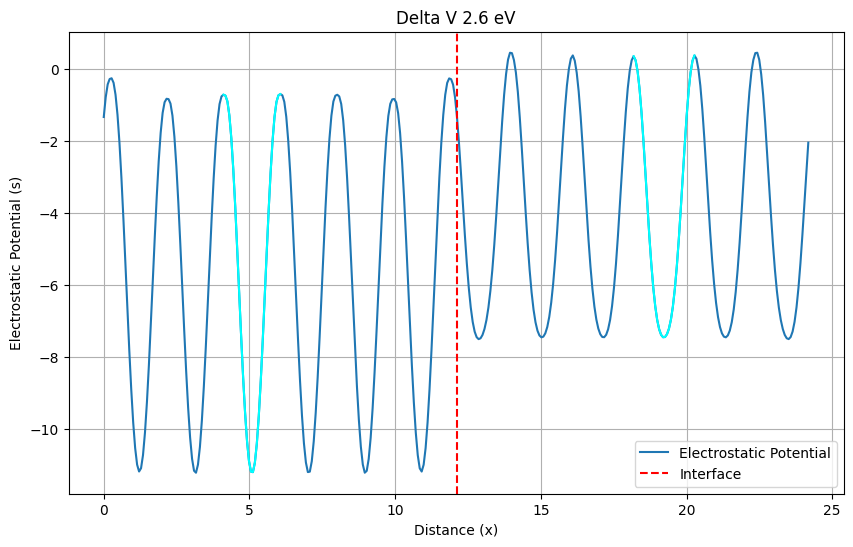

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from intermat.analyze import locpot_mean
%matplotlib inline
import matplotlib.pyplot as plt


x, s, _ = locpot_mean('LOCPOT')


# Step 1: Assume the middle is the interface
interface_index = len(x) // 2
interface_x = x[interface_index]

# Step 2: Identify peaks in the potential data to find repeat units
peaks, _ = find_peaks(s, width=5,prominence=1)
peak_positions = x[peaks]

# Step 3: Find the closest repeat unit to the left and right of the interface
left_side=peak_positions[peak_positions < interface_x]
left_index=int(np.ceil(len(left_side)/2))-1
print('left_side',left_side,len(left_side),left_index)
left_repeat_end = left_side[left_index]
left_repeat_start = peak_positions[peak_positions < left_repeat_end][-1]

right_side=peak_positions[peak_positions > interface_x]
right_index=int(np.ceil(len(right_side)/2))-1

print('right_side',right_side,len(right_side),right_index)

right_repeat_start = right_side[right_index]
right_repeat_end = peak_positions[peak_positions > right_repeat_start][0]

# Step 4: Calculate integrals over the left and right repeat units
# Left-hand side repeat unit
mask_left = (x >= left_repeat_start) & (x <= left_repeat_end)
integral_left = np.trapz(s[mask_left], x[mask_left])

# Right-hand side repeat unit
mask_right = (x >= right_repeat_start) & (x <= right_repeat_end)
integral_right = np.trapz(s[mask_right], x[mask_right])

# Step 5: Calculate the difference between the two integrals
integral_difference = integral_right - integral_left

# Print results
print(f"Left Repeat Unit: [{left_repeat_start}, {left_repeat_end}]")
print(f"Right Repeat Unit: [{right_repeat_start}, {right_repeat_end}]")
print(f"Integral over Left-Hand Side Repeat Unit: {integral_left}")
print(f"Integral over Right-Hand Side Repeat Unit: {integral_right}")
print(f"Difference Between Integrals: {integral_difference}")

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(x, s, label="Electrostatic Potential")
plt.axvline(x=interface_x, color="red", linestyle="--", label="Interface")
plt.plot(x[mask_left], s[mask_left],  color="cyan")
plt.plot(x[mask_right], s[mask_right],color="cyan" )
plt.xlabel("Distance (x)")
plt.ylabel("Electrostatic Potential (s)")
plt.title("Delta V "+str(round(integral_difference,2))+" eV")
plt.legend()
plt.grid()
plt.show()


Left Repeat Unit: [4.108410749810933, 6.061589630868589]
Right Repeat Unit: [18.184768892605767, 20.272649765460503]
Integral over Left-Hand Side Repeat Unit: -10.993212027567518
Integral over Right-Hand Side Repeat Unit: -8.392714196392216
Difference Between Integrals: 2.6004978311753018
Average Potential (Left): -5.464462918301655
Average Potential (Right): -3.882876933576317


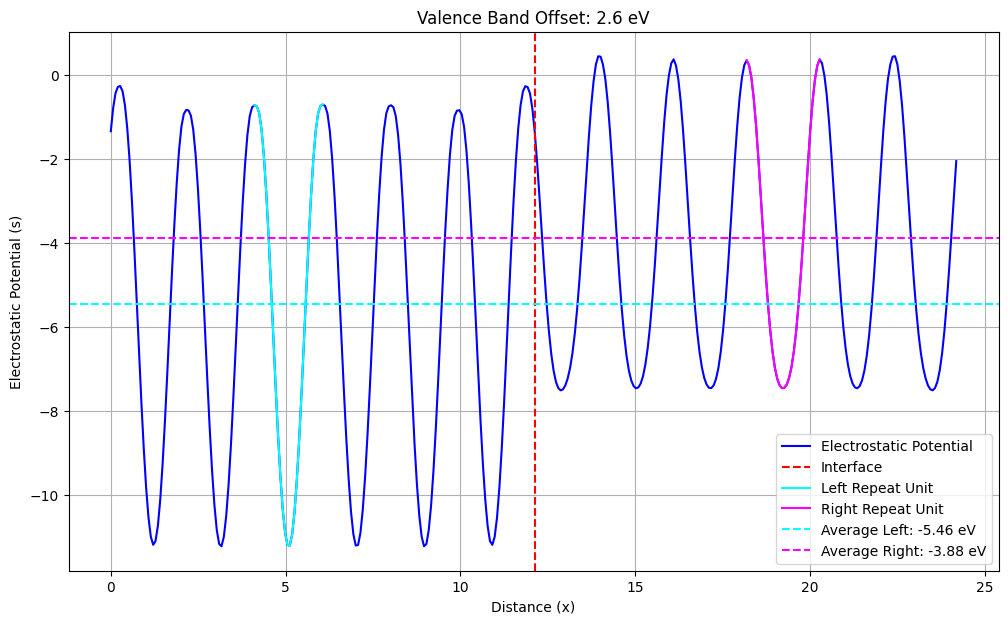

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from intermat.analyze import locpot_mean

%matplotlib inline

# Load the potential data
#x, s, _ = locpot_mean('LOCPOT')

# Step 1: Assume the middle is the interface
interface_index = len(x) // 2
interface_x = x[interface_index]

# Step 2: Identify peaks in the potential data to find repeat units
peaks, _ = find_peaks(s, width=5, prominence=1)
peak_positions = x[peaks]

# Step 3: Find the closest repeat unit to the left and right of the interface
left_side = peak_positions[peak_positions < interface_x]
left_index = int(np.ceil(len(left_side) / 2)) - 1
left_repeat_end = left_side[left_index]
left_repeat_start = peak_positions[peak_positions < left_repeat_end][-1]

right_side = peak_positions[peak_positions > interface_x]
right_index = int(np.ceil(len(right_side) / 2)) - 1
right_repeat_start = right_side[right_index]
right_repeat_end = peak_positions[peak_positions > right_repeat_start][0]

# Step 4: Calculate integrals and averages over the left and right repeat units
# Left-hand side repeat unit
mask_left = (x >= left_repeat_start) & (x <= left_repeat_end)
integral_left = np.trapz(s[mask_left], x[mask_left])
average_left = np.mean(s[mask_left])

# Right-hand side repeat unit
mask_right = (x >= right_repeat_start) & (x <= right_repeat_end)
integral_right = np.trapz(s[mask_right], x[mask_right])
average_right = np.mean(s[mask_right])

# Step 5: Calculate the difference between the two integrals
integral_difference = integral_right - integral_left

# Print results
print(f"Left Repeat Unit: [{left_repeat_start}, {left_repeat_end}]")
print(f"Right Repeat Unit: [{right_repeat_start}, {right_repeat_end}]")
print(f"Integral over Left-Hand Side Repeat Unit: {integral_left}")
print(f"Integral over Right-Hand Side Repeat Unit: {integral_right}")
print(f"Difference Between Integrals: {integral_difference}")
print(f"Average Potential (Left): {average_left}")
print(f"Average Potential (Right): {average_right}")

# Visualize
plt.figure(figsize=(12, 7))
plt.plot(x, s, label="Electrostatic Potential", color="blue")
plt.axvline(x=interface_x, color="red", linestyle="--", label="Interface")
plt.plot(x[mask_left], s[mask_left], color="cyan", label="Left Repeat Unit")
plt.plot(x[mask_right], s[mask_right], color="magenta", label="Right Repeat Unit")

# Plot averages
plt.axhline(y=average_left, color="cyan", linestyle="--", label=f"Average Left: {average_left:.2f} eV")
plt.axhline(y=average_right, color="magenta", linestyle="--", label=f"Average Right: {average_right:.2f} eV")

plt.xlabel("Distance (x)")
plt.ylabel("Electrostatic Potential (s)")
plt.title(f"Valence Band Offset: {round(integral_difference, 2)} eV")
plt.legend()
plt.grid()
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

def locpot_mean(fname="LOCPOT"):
    """Load and preprocess electrostatic potential data."""
    # Replace this with the actual implementation for your environment
    # Assuming x and s are the position and potential arrays
    x = np.linspace(0, 100, 1000)  # Dummy x-values
    s = np.sin(x / 10) * 10 + np.random.random(1000)  # Dummy potential values
    return x, s, None

def calculate_repeat_units(x, s, width=5):
    """Identify peaks and calculate repeat units."""
    peaks, _ = find_peaks(s, width=width, prominence=1)
    peak_positions = x[peaks]
    return peaks, peak_positions

def best_repeat_unit(x, s, peaks, region_indices):
    """Determine the best repeat unit length."""
    region = x[region_indices]
    start, end = region[0], region[-1]
    spline = CubicSpline(x, s)

    def recursive_optimization(start, end, spline, region):
        best_L = 0
        best_error = float('inf')
        step = (end - start) / 10
        for L in np.arange(start, end, step):
            error = sum(abs(spline(r) - spline(r + L)) for r in region if r + L < max(x))
            if error < best_error:
                best_error = error
                best_L = L
        return best_L

    return recursive_optimization(start, end, spline, region)

def calculate_average_potential(x, s, L, region_indices):
    """Compute average potential over the identified repeat unit."""
    spline = CubicSpline(x, s)

    def region_average(region):
        return [quad(spline, r - L / 2, r + L / 2)[0] / L for r in region if r - L / 2 > min(x) and r + L / 2 < max(x)]

    return region_average(region_indices)

def compute_offset(fname="LOCPOT"):
    """Main function to compute valence band offset."""
    x, s, _ = locpot_mean(fname)
    peaks, peak_positions = calculate_repeat_units(x, s)

    # Interface as middle
    interface_index = len(x) // 2
    interface_x = x[interface_index]

    # Left and right regions
    left_indices = peaks[peaks < interface_index]
    right_indices = peaks[peaks > interface_index]

    # Optimize repeat unit length
    L_left = best_repeat_unit(x, s, peaks, left_indices)
    L_right = best_repeat_unit(x, s, peaks, right_indices)

    # Calculate average potentials
    left_avg = calculate_average_potential(x, s, L_left, left_indices)
    right_avg = calculate_average_potential(x, s, L_right, right_indices)

    # Offset calculation
    delta_V = np.mean(right_avg) - np.mean(left_avg)

    # Visualization
    plt.figure(figsize=(12, 7))
    plt.plot(x, s, label="Electrostatic Potential")
    plt.axvline(interface_x, color="red", linestyle="--", label="Interface")
    plt.axhline(np.mean(left_avg), color="blue", linestyle="--", label=f"Left Avg: {np.mean(left_avg):.2f} eV")
    plt.axhline(np.mean(right_avg), color="green", linestyle="--", label=f"Right Avg: {np.mean(right_avg):.2f} eV")
    plt.xlabel("Distance (x)")
    plt.ylabel("Electrostatic Potential (s)")
    plt.title(f"Valence Band Offset: {delta_V:.2f} eV")
    plt.legend()
    plt.grid()
    plt.show()

    return delta_V

# Example usage
offset = compute_offset()
print(f"Computed Valence Band Offset: {offset:.2f} eV")


<ipython-input-7-09dcee29b184>:31: RuntimeWarning: invalid value encountered in scalar divide
  for L in np.arange(start, end, step):


ValueError: arange: cannot compute length

Old approach

Check polar False
Number of peaks  11
use input left index
left index  -2
Initial guess left  2.0205298769561963
Lleft  2.0955117990772294


/usr/local/lib/python3.10/dist-packages/intermat/analyze.py:206: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y)[0]


Initial guess right  1.8858278851591166
Lright  1.9468003430130245
meanval  [-4.001625310860106, -5.649582614872947] -1.6479573040128406 -1.6479573040128406
deltaE 0


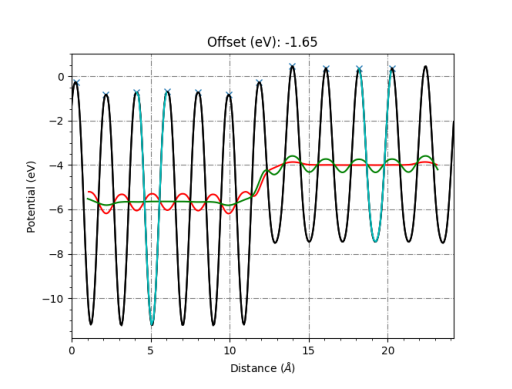

In [ ]:
from intermat.analyze import locpot_mean, offset
info=offset(x=x,s=s,polar=False,deltaE=0,left_index=-2)
plt.imshow(plt.imread('offset.png'))
plt.axis('off')
plt.show()

# Note Delta_V not offset, as deltaE manually set to zeo